# [try] hidden_size_listの数字を変更してみよう

In [1]:
import sys, os
sys.path.append(os.pardir)
from data.mnist import load_mnist
from common import layers
from common import functions

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
class MultiLayerNet:
    '''
    input_size: 入力層のノード数
    hidden_size_list: 隠れ層のノード数のリスト
    output_size: 出力層のノード数
    activation: 活性化関数
    weight_init_std: 重みの初期化方法
    '''
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu'):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成, sigmoidとreluのみ扱う
        activation_layer = {'sigmoid': layers.Sigmoid, 'relu': layers.Relu}
        self.layers = OrderedDict() # 追加した順番に格納
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = layers.SoftmaxWithLoss()
    
    ### ◆◆◆　重みの初期値　◆◆◆
    def __init_weight(self, weight_init_std):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, d):
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]

        return self.last_layer.forward(y, d) + weight_decay

    def accuracy(self, x, d):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if d.ndim != 1 : d = np.argmax(d, axis=1)

        accuracy = np.sum(y == d) / float(x.shape[0])
        return accuracy

    def gradient(self, x, d):
        # forward
        self.loss(x, d)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        for idx in range(1, self.hidden_layer_num+2):
            grad['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grad['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grad


### シグモイド関数の場合
重みの初期値は標準正規分布 \
※`weight_init_std=0.01`で指定している

hidden_size_list=[100, 30]

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.1
                : 200. 正答率(テスト) = 0.1135
Generation: 400. 正答率(トレーニング) = 0.09
                : 400. 正答率(テスト) = 0.1135
Generation: 600. 正答率(トレーニング) = 0.18
                : 600. 正答率(テスト) = 0.1135
Generation: 800. 正答率(トレーニング) = 0.12
                : 800. 正答率(テスト) = 0.1135
Generation: 1000. 正答率(トレーニング) = 0.11
                : 1000. 正答率(テスト) = 0.1135
Generation: 1200. 正答率(トレーニング) = 0.11
                : 1200. 正答率(テスト) = 0.1028
Generation: 1400. 正答率(トレーニング) = 0.11
                : 1400. 正答率(テスト) = 0.1135
Generation: 1600. 正答率(トレーニング) = 0.12
                : 1600. 正答率(テスト) = 0.1135
Generation: 1800. 正答率(トレーニング) = 0.16
                : 1800. 正答率(テスト) = 0.0982
Generation: 2000. 正答率(トレーニング) = 0.12
                : 2000. 正答率(テスト) = 0.1711


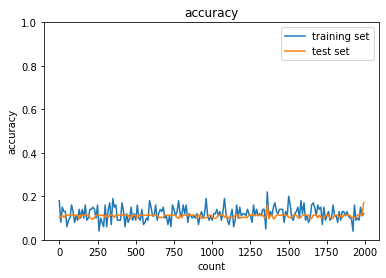

In [3]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01)
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 30], output_size=10, activation='sigmoid', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        ## ●●●ログ出力の件数が多いため、２００回に１回出力するように修正●●●
        if (i + 1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="upper right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### シグモイド関数の場合
重みの初期値は標準正規分布 \
※`weight_init_std=0.01`で指定している

hidden_size_list=[200, 50]

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.14
                : 200. 正答率(テスト) = 0.1135
Generation: 400. 正答率(トレーニング) = 0.11
                : 400. 正答率(テスト) = 0.1135
Generation: 600. 正答率(トレーニング) = 0.09
                : 600. 正答率(テスト) = 0.1135
Generation: 800. 正答率(トレーニング) = 0.15
                : 800. 正答率(テスト) = 0.1135
Generation: 1000. 正答率(トレーニング) = 0.17
                : 1000. 正答率(テスト) = 0.1028
Generation: 1200. 正答率(トレーニング) = 0.14
                : 1200. 正答率(テスト) = 0.101
Generation: 1400. 正答率(トレーニング) = 0.1
                : 1400. 正答率(テスト) = 0.1135
Generation: 1600. 正答率(トレーニング) = 0.18
                : 1600. 正答率(テスト) = 0.1032
Generation: 1800. 正答率(トレーニング) = 0.14
                : 1800. 正答率(テスト) = 0.1135
Generation: 2000. 正答率(トレーニング) = 0.09
                : 2000. 正答率(テスト) = 0.1135


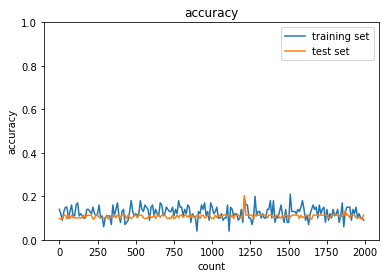

In [4]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01)
network = MultiLayerNet(input_size=784, hidden_size_list=[200, 50], output_size=10, activation='sigmoid', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        ## ●●●ログ出力の件数が多いため、２００回に１回出力するように修正●●●
        if (i + 1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="upper right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### シグモイド関数の場合
重みの初期値はXavier

hidden_size_list=[100, 30]

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.5
                : 200. 正答率(テスト) = 0.3931
Generation: 400. 正答率(トレーニング) = 0.65
                : 400. 正答率(テスト) = 0.559
Generation: 600. 正答率(トレーニング) = 0.64
                : 600. 正答率(テスト) = 0.6917
Generation: 800. 正答率(トレーニング) = 0.84
                : 800. 正答率(テスト) = 0.7514
Generation: 1000. 正答率(トレーニング) = 0.83
                : 1000. 正答率(テスト) = 0.7983
Generation: 1200. 正答率(トレーニング) = 0.84
                : 1200. 正答率(テスト) = 0.8413
Generation: 1400. 正答率(トレーニング) = 0.92
                : 1400. 正答率(テスト) = 0.8592
Generation: 1600. 正答率(トレーニング) = 0.92
                : 1600. 正答率(テスト) = 0.8731
Generation: 1800. 正答率(トレーニング) = 0.86
                : 1800. 正答率(テスト) = 0.8799
Generation: 2000. 正答率(トレーニング) = 0.82
                : 2000. 正答率(テスト) = 0.8866


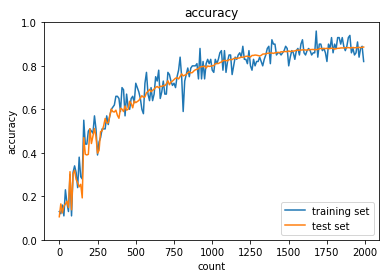

In [5]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 30], output_size=10, activation='sigmoid', weight_init_std='Xavier')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        ## ●●●ログ出力の件数が多いため、２００回に１回出力するように修正●●●
        if (i + 1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### シグモイド関数の場合
重みの初期値はXavier

hidden_size_list=[200, 50]

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.33
                : 200. 正答率(テスト) = 0.2586
Generation: 400. 正答率(トレーニング) = 0.66
                : 400. 正答率(テスト) = 0.6402
Generation: 600. 正答率(トレーニング) = 0.72
                : 600. 正答率(テスト) = 0.7433
Generation: 800. 正答率(トレーニング) = 0.67
                : 800. 正答率(テスト) = 0.792
Generation: 1000. 正答率(トレーニング) = 0.78
                : 1000. 正答率(テスト) = 0.8217
Generation: 1200. 正答率(トレーニング) = 0.8
                : 1200. 正答率(テスト) = 0.8536
Generation: 1400. 正答率(トレーニング) = 0.89
                : 1400. 正答率(テスト) = 0.8666
Generation: 1600. 正答率(トレーニング) = 0.89
                : 1600. 正答率(テスト) = 0.8787
Generation: 1800. 正答率(トレーニング) = 0.87
                : 1800. 正答率(テスト) = 0.8856
Generation: 2000. 正答率(トレーニング) = 0.85
                : 2000. 正答率(テスト) = 0.8903


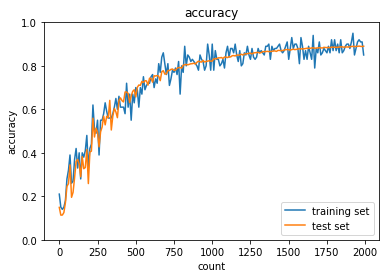

In [6]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[200, 50], output_size=10, activation='sigmoid', weight_init_std='Xavier')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        ## ●●●ログ出力の件数が多いため、２００回に１回出力するように修正●●●
        if (i + 1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### シグモイド関数の場合
重みの初期値はHe

hidden_size_list=[100, 30]

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.68
                : 200. 正答率(テスト) = 0.6324
Generation: 400. 正答率(トレーニング) = 0.79
                : 400. 正答率(テスト) = 0.7107
Generation: 600. 正答率(トレーニング) = 0.85
                : 600. 正答率(テスト) = 0.7783
Generation: 800. 正答率(トレーニング) = 0.86
                : 800. 正答率(テスト) = 0.8243
Generation: 1000. 正答率(トレーニング) = 0.83
                : 1000. 正答率(テスト) = 0.8535
Generation: 1200. 正答率(トレーニング) = 0.94
                : 1200. 正答率(テスト) = 0.872
Generation: 1400. 正答率(トレーニング) = 0.88
                : 1400. 正答率(テスト) = 0.8834
Generation: 1600. 正答率(トレーニング) = 0.9
                : 1600. 正答率(テスト) = 0.8891
Generation: 1800. 正答率(トレーニング) = 0.87
                : 1800. 正答率(テスト) = 0.8942
Generation: 2000. 正答率(トレーニング) = 0.83
                : 2000. 正答率(テスト) = 0.8983


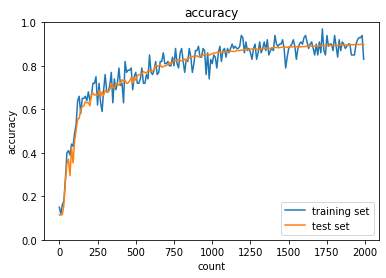

In [8]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 30], output_size=10, activation='sigmoid', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        ## ●●●ログ出力の件数が多いため、２００回に１回出力するように修正●●●
        if (i + 1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### シグモイド関数の場合
重みの初期値はHe

hidden_size_list=[200, 50]

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.7
                : 200. 正答率(テスト) = 0.6771
Generation: 400. 正答率(トレーニング) = 0.76
                : 400. 正答率(テスト) = 0.7654
Generation: 600. 正答率(トレーニング) = 0.81
                : 600. 正答率(テスト) = 0.8429
Generation: 800. 正答率(トレーニング) = 0.93
                : 800. 正答率(テスト) = 0.864
Generation: 1000. 正答率(トレーニング) = 0.86
                : 1000. 正答率(テスト) = 0.8766
Generation: 1200. 正答率(トレーニング) = 0.9
                : 1200. 正答率(テスト) = 0.8865
Generation: 1400. 正答率(トレーニング) = 0.91
                : 1400. 正答率(テスト) = 0.8904
Generation: 1600. 正答率(トレーニング) = 0.92
                : 1600. 正答率(テスト) = 0.8966
Generation: 1800. 正答率(トレーニング) = 0.92
                : 1800. 正答率(テスト) = 0.8993
Generation: 2000. 正答率(トレーニング) = 0.92
                : 2000. 正答率(テスト) = 0.9025


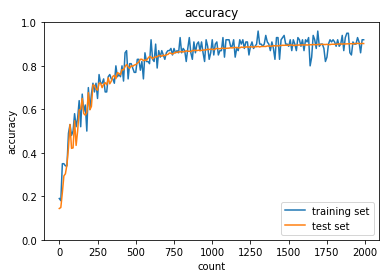

In [9]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[200, 50], output_size=10, activation='sigmoid', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        ## ●●●ログ出力の件数が多いため、２００回に１回出力するように修正●●●
        if (i + 1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### ReLU関数の場合
重みの初期値は標準正規分布 \
※`weight_init_std=0.01`で指定している

hidden_size_list=[100, 30]

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.1
                : 200. 正答率(テスト) = 0.1135
Generation: 400. 正答率(トレーニング) = 0.22
                : 400. 正答率(テスト) = 0.2243
Generation: 600. 正答率(トレーニング) = 0.77
                : 600. 正答率(テスト) = 0.7083
Generation: 800. 正答率(トレーニング) = 0.88
                : 800. 正答率(テスト) = 0.8315
Generation: 1000. 正答率(トレーニング) = 0.87
                : 1000. 正答率(テスト) = 0.8555
Generation: 1200. 正答率(トレーニング) = 0.92
                : 1200. 正答率(テスト) = 0.8927
Generation: 1400. 正答率(トレーニング) = 0.98
                : 1400. 正答率(テスト) = 0.9064
Generation: 1600. 正答率(トレーニング) = 0.98
                : 1600. 正答率(テスト) = 0.9171
Generation: 1800. 正答率(トレーニング) = 0.98
                : 1800. 正答率(テスト) = 0.9287
Generation: 2000. 正答率(トレーニング) = 0.96
                : 2000. 正答率(テスト) = 0.9355


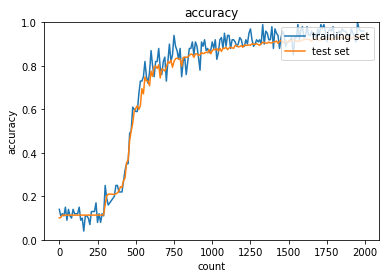

In [10]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 30], output_size=10, activation='relu', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        ## ●●●ログ出力の件数が多いため、２００回に１回出力するように修正●●●
        if (i + 1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="upper right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### ReLU関数の場合
重みの初期値は標準正規分布 \
※`weight_init_std=0.01`で指定している

hidden_size_list=[200, 50]

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.13
                : 200. 正答率(テスト) = 0.1135
Generation: 400. 正答率(トレーニング) = 0.65
                : 400. 正答率(テスト) = 0.6074
Generation: 600. 正答率(トレーニング) = 0.83
                : 600. 正答率(テスト) = 0.8247
Generation: 800. 正答率(トレーニング) = 0.9
                : 800. 正答率(テスト) = 0.8624
Generation: 1000. 正答率(トレーニング) = 0.9
                : 1000. 正答率(テスト) = 0.8945
Generation: 1200. 正答率(トレーニング) = 0.9
                : 1200. 正答率(テスト) = 0.9131
Generation: 1400. 正答率(トレーニング) = 0.96
                : 1400. 正答率(テスト) = 0.9232
Generation: 1600. 正答率(トレーニング) = 0.95
                : 1600. 正答率(テスト) = 0.9337
Generation: 1800. 正答率(トレーニング) = 0.97
                : 1800. 正答率(テスト) = 0.9347
Generation: 2000. 正答率(トレーニング) = 0.97
                : 2000. 正答率(テスト) = 0.9399


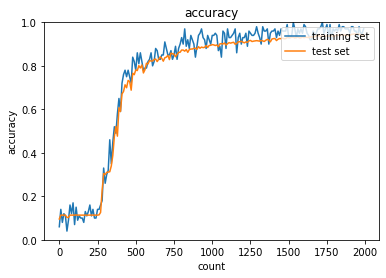

In [11]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[200, 50], output_size=10, activation='relu', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        ## ●●●ログ出力の件数が多いため、２００回に１回出力するように修正●●●
        if (i + 1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="upper right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### ReLU関数の場合
重みの初期値はXavier

hidden_size_list=[100, 30]

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.91
                : 200. 正答率(テスト) = 0.8925
Generation: 400. 正答率(トレーニング) = 0.96
                : 400. 正答率(テスト) = 0.917
Generation: 600. 正答率(トレーニング) = 0.95
                : 600. 正答率(テスト) = 0.9276
Generation: 800. 正答率(トレーニング) = 0.96
                : 800. 正答率(テスト) = 0.9365
Generation: 1000. 正答率(トレーニング) = 0.95
                : 1000. 正答率(テスト) = 0.9402
Generation: 1200. 正答率(トレーニング) = 0.96
                : 1200. 正答率(テスト) = 0.9457
Generation: 1400. 正答率(トレーニング) = 0.97
                : 1400. 正答率(テスト) = 0.9479
Generation: 1600. 正答率(トレーニング) = 0.99
                : 1600. 正答率(テスト) = 0.9517
Generation: 1800. 正答率(トレーニング) = 0.99
                : 1800. 正答率(テスト) = 0.9536
Generation: 2000. 正答率(トレーニング) = 0.97
                : 2000. 正答率(テスト) = 0.9589


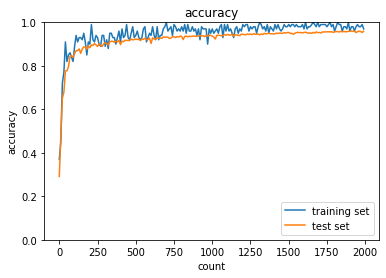

In [12]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 30], output_size=10, activation='relu', weight_init_std='Xavier')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        ## ●●●ログ出力の件数が多いため、２００回に１回出力するように修正●●●
        if (i + 1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### ReLU関数の場合
重みの初期値はXavier

hidden_size_list=[200, 50]

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.95
                : 200. 正答率(テスト) = 0.8977
Generation: 400. 正答率(トレーニング) = 0.95
                : 400. 正答率(テスト) = 0.9215
Generation: 600. 正答率(トレーニング) = 0.98
                : 600. 正答率(テスト) = 0.9279
Generation: 800. 正答率(トレーニング) = 0.97
                : 800. 正答率(テスト) = 0.9372
Generation: 1000. 正答率(トレーニング) = 0.99
                : 1000. 正答率(テスト) = 0.9493
Generation: 1200. 正答率(トレーニング) = 0.98
                : 1200. 正答率(テスト) = 0.9521
Generation: 1400. 正答率(トレーニング) = 0.96
                : 1400. 正答率(テスト) = 0.9553
Generation: 1600. 正答率(トレーニング) = 1.0
                : 1600. 正答率(テスト) = 0.9594
Generation: 1800. 正答率(トレーニング) = 0.98
                : 1800. 正答率(テスト) = 0.9639
Generation: 2000. 正答率(トレーニング) = 0.98
                : 2000. 正答率(テスト) = 0.9635


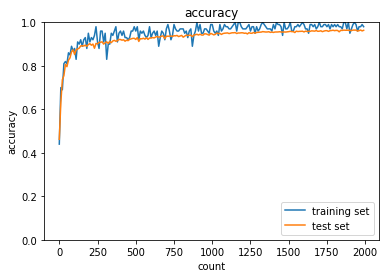

In [13]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[200, 50], output_size=10, activation='relu', weight_init_std='Xavier')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        ## ●●●ログ出力の件数が多いため、２００回に１回出力するように修正●●●
        if (i + 1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### ReLU関数の場合
重みの初期値はHe

hidden_size_list=[100, 30]

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.94
                : 200. 正答率(テスト) = 0.8912
Generation: 400. 正答率(トレーニング) = 0.95
                : 400. 正答率(テスト) = 0.9255
Generation: 600. 正答率(トレーニング) = 0.99
                : 600. 正答率(テスト) = 0.9355
Generation: 800. 正答率(トレーニング) = 1.0
                : 800. 正答率(テスト) = 0.9427
Generation: 1000. 正答率(トレーニング) = 0.98
                : 1000. 正答率(テスト) = 0.9468
Generation: 1200. 正答率(トレーニング) = 0.95
                : 1200. 正答率(テスト) = 0.9535
Generation: 1400. 正答率(トレーニング) = 0.98
                : 1400. 正答率(テスト) = 0.9564
Generation: 1600. 正答率(トレーニング) = 0.97
                : 1600. 正答率(テスト) = 0.9584
Generation: 1800. 正答率(トレーニング) = 0.97
                : 1800. 正答率(テスト) = 0.9589
Generation: 2000. 正答率(トレーニング) = 1.0
                : 2000. 正答率(テスト) = 0.9575


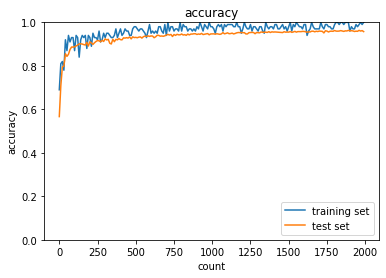

In [14]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 30], output_size=10, activation='relu', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        ## ●●●ログ出力の件数が多いため、２００回に１回出力するように修正●●●
        if (i + 1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### ReLU関数の場合
重みの初期値はHe

hidden_size_list=[200, 50]

データ読み込み完了
Generation: 200. 正答率(トレーニング) = 0.92
                : 200. 正答率(テスト) = 0.9104
Generation: 400. 正答率(トレーニング) = 0.92
                : 400. 正答率(テスト) = 0.9121
Generation: 600. 正答率(トレーニング) = 0.97
                : 600. 正答率(テスト) = 0.933
Generation: 800. 正答率(トレーニング) = 0.96
                : 800. 正答率(テスト) = 0.9422
Generation: 1000. 正答率(トレーニング) = 0.99
                : 1000. 正答率(テスト) = 0.9525
Generation: 1200. 正答率(トレーニング) = 0.96
                : 1200. 正答率(テスト) = 0.9549
Generation: 1400. 正答率(トレーニング) = 0.98
                : 1400. 正答率(テスト) = 0.9587
Generation: 1600. 正答率(トレーニング) = 1.0
                : 1600. 正答率(テスト) = 0.9642
Generation: 1800. 正答率(トレーニング) = 1.0
                : 1800. 正答率(テスト) = 0.9639
Generation: 2000. 正答率(トレーニング) = 0.99
                : 2000. 正答率(テスト) = 0.9676


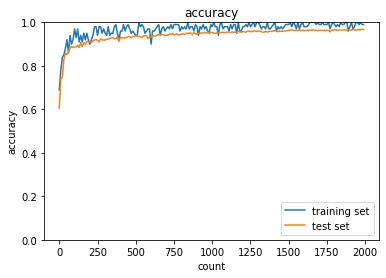

In [15]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[200, 50], output_size=10, activation='relu', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        ## ●●●ログ出力の件数が多いため、２００回に１回出力するように修正●●●
        if (i + 1) % 200 == 0:
            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()